# DL Problem Statement

**Name:** 3418 Avadhesh Yadav  
**Class:** BE COMP-A  
**Student:** Avadhesh Yadav


# Problem Statement
In this assignment you need to implement a feedforward neural network and write the backpropagation code for training the network. We strongly recommend using numpy for all matrix/vector operations. You are not allowed to use any automatic differentiation packages. This network will be trained and tested using the Fashion-MNIST dataset. Specifically, given an input image (28 x 28 = 784 pixels) from the Fashion-MNIST dataset, the network will be trained to classify the image into 1 of 10 classes.


## Question 1
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

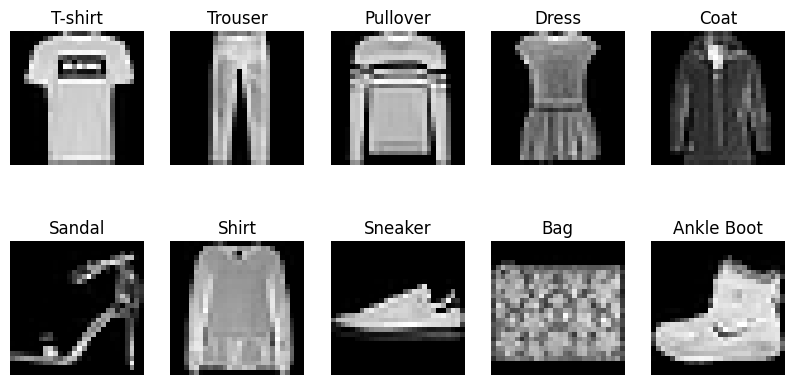

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape images to vectors (28x28 = 784)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Class labels
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Plot one sample image from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    index = np.where(y_train == i)[0][0]
    axes[i].imshow(x_train[index].reshape(28, 28), cmap='gray')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')
plt.show()


## Question 2
Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.
Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.
We will check the code for implementation and ease of use.

In [2]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, optimizer="sgd"):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.initialize_weights()
        self.initialize_optimizer_cache()

    def initialize_weights(self):
        self.weights = {}
        self.biases = {}

        for i in range(1, len(self.layer_sizes)):
            self.weights[i] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * 0.01
            self.biases[i] = np.zeros((self.layer_sizes[i], 1))

    def initialize_optimizer_cache(self):
        self.v = {i: np.zeros_like(w) for i, w in self.weights.items()}  # Momentum
        self.s = {i: np.zeros_like(w) for i, w in self.weights.items()}  # RMSprop

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def forward_propagation(self, X):
        activations = {0: X}
        zs = {}

        for i in range(1, len(self.layer_sizes)):
            zs[i] = np.dot(self.weights[i], activations[i - 1]) + self.biases[i]
            if i == len(self.layer_sizes) - 1:
                activations[i] = self.softmax(zs[i])
            else:
                activations[i] = self.sigmoid(zs[i])

        return activations, zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward_propagation(self, activations, zs, y_true):
        m = y_true.shape[1]
        grads = {}

        dz = activations[len(self.layer_sizes) - 1] - y_true
        for i in reversed(range(1, len(self.layer_sizes))):
            grads[f'dW{i}'] = np.dot(dz, activations[i - 1].T) / m
            grads[f'db{i}'] = np.sum(dz, axis=1, keepdims=True) / m
            if i > 1:
                dz = np.dot(self.weights[i].T, dz) * activations[i - 1] * (1 - activations[i - 1])

        return grads

    def update_weights(self, grads, t=1):
        for i in range(1, len(self.layer_sizes)):
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * grads[f'dW{i}']
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "momentum":
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nesterov":
                v_prev = self.v[i]
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= 0.9 * v_prev + (1 + 0.9) * self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "rmsprop":
                self.s[i] = 0.9 * self.s[i] + 0.1 * grads[f'dW{i}']**2
                self.weights[i] -= self.learning_rate * grads[f'dW{i}'] / (np.sqrt(self.s[i]) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "adam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                self.weights[i] -= self.learning_rate * v_corrected / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nadam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                m_hat = beta1 * v_corrected + (1 - beta1) * grads[f'dW{i}']
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

    def train(self, X, y, epochs=10, batch_size=32):
        m = X.shape[1]
        for epoch in range(epochs):
            for i in range(0, m, batch_size):
                X_batch = X[:, i:i+batch_size]
                y_batch = y[:, i:i+batch_size]

                activations, zs = self.forward_propagation(X_batch)
                grads = self.backward_propagation(activations, zs, y_batch)
                self.update_weights(grads, epoch+1)

            loss = self.compute_loss(y, self.forward_propagation(X)[0][len(self.layer_sizes) - 1])
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


## Question 3
Implement the backpropagation algorithm with support for the following optimisation functions
•	sgd
•	momentum based gradient descent
•	nesterov accelerated gradient descent
•	rmsprop
•	adam
•	nadam
(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above) We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

In [22]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, optimizer="sgd"):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.weight_decay = weight_decay
        self.initialize_weights()
        self.initialize_optimizer_cache()

    def initialize_weights(self):
        self.weights = {}
        self.biases = {}

        for i in range(1, len(self.layer_sizes)):
            self.weights[i] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * 0.01
            self.biases[i] = np.zeros((self.layer_sizes[i], 1))

    def initialize_optimizer_cache(self):
        self.v = {i: np.zeros_like(w) for i, w in self.weights.items()}  # Momentum
        self.s = {i: np.zeros_like(w) for i, w in self.weights.items()}  # RMSprop

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def forward_propagation(self, X):
        activations = {0: X}
        zs = {}

        for i in range(1, len(self.layer_sizes)):
            zs[i] = np.dot(self.weights[i], activations[i - 1]) + self.biases[i]
            if i == len(self.layer_sizes) - 1:
                activations[i] = self.softmax(zs[i])
            else:
                activations[i] = self.sigmoid(zs[i])

        return activations, zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward_propagation(self, activations, zs, y_true):
        m = y_true.shape[1]
        grads = {}

        dz = activations[len(self.layer_sizes) - 1] - y_true
        for i in reversed(range(1, len(self.layer_sizes))):
            grads[f'dW{i}'] = np.dot(dz, activations[i - 1].T) / m
            grads[f'db{i}'] = np.sum(dz, axis=1, keepdims=True) / m
            if i > 1:
                dz = np.dot(self.weights[i].T, dz) * activations[i - 1] * (1 - activations[i - 1])

        return grads

    def update_weights(self, grads, t=1):
        for i in range(1, len(self.layer_sizes)):
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * grads[f'dW{i}']
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "momentum":
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nesterov":
                v_prev = self.v[i]
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= 0.9 * v_prev + (1 + 0.9) * self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "rmsprop":
                self.s[i] = 0.9 * self.s[i] + 0.1 * grads[f'dW{i}']**2
                self.weights[i] -= self.learning_rate * grads[f'dW{i}'] / (np.sqrt(self.s[i]) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "adam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                self.weights[i] -= self.learning_rate * v_corrected / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nadam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                m_hat = beta1 * v_corrected + (1 - beta1) * grads[f'dW{i}']
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

    def train(self, X, y, epochs=10, batch_size=32):
        m = X.shape[1]
        for epoch in range(epochs):
            for i in range(0, m, batch_size):
                X_batch = X[:, i:i+batch_size]
                y_batch = y[:, i:i+batch_size]

                activations, zs = self.forward_propagation(X_batch)
                grads = self.backward_propagation(activations, zs, y_batch)
                self.update_weights(grads, epoch+1)

            loss = self.compute_loss(y, self.forward_propagation(X)[0][len(self.layer_sizes) - 1])
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


In [3]:
nn = NeuralNetwork([784, 128, 64, 10], learning_rate=0.01, optimizer="adam")
nn.train(x_train.T, np.eye(10)[y_train].T, epochs=10, batch_size=64)


Epoch 1/10, Loss: 0.4160
Epoch 2/10, Loss: 0.3530
Epoch 3/10, Loss: 0.3257
Epoch 4/10, Loss: 0.3077
Epoch 5/10, Loss: 0.2927
Epoch 6/10, Loss: 0.2813
Epoch 7/10, Loss: 0.2707
Epoch 8/10, Loss: 0.2632
Epoch 9/10, Loss: 0.2564
Epoch 10/10, Loss: 0.2501


## Question 4
Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.
•	number of epochs: 5, 10
•	number of hidden layers: 3, 4, 5
•	size of every hidden layer: 32, 64, 128
•	weight decay (L2 regularisation): 0, 0.0005, 0.5
•	learning rate: 1e-3, 1 e-4
•	optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
•	batch size: 16, 32, 64
•	weight initialisation: random, Xavier
•	activation functions: sigmoid, tanh, ReLU
wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [4]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ashuyadav929 (ashuyadav929-army-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
sweep_config = {
    "method": "bayes",  # Bayesian optimization for efficiency
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
    },
}
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-hyperparam-tuning")


Create sweep with ID: 6d38nh3w
Sweep URL: https://wandb.ai/ashuyadav929-army-institute-of-technology/fashion-mnist-hyperparam-tuning/sweeps/6d38nh3w


In [6]:
def train_model():
    run = wandb.init()
    config = run.config

    # Prepare dataset (Fashion-MNIST)
    from keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Convert labels to one-hot encoding
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # Split training into train and validation sets (90%-10%)
    val_split = int(0.9 * len(X_train))
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    # Initialize the neural network
    nn = NeuralNetwork(
        layer_sizes=[784] + [config.hidden_size] * config.hidden_layers + [10],
        learning_rate=config.learning_rate,
        optimizer=config.optimizer
    )

    # Training loop
    for epoch in range(config.epochs):
        nn.train(X_train.T, y_train.T, epochs=1, batch_size=config.batch_size)
        val_loss = nn.compute_loss(y_val.T, nn.forward_propagation(X_val.T)[0][len(nn.layer_sizes) - 1])
        
        wandb.log({"epoch": epoch + 1, "val_loss": val_loss})

    run.finish()


In [7]:
wandb.agent(sweep_id, function=train_model, count=20)

wandb: Agent Starting Run: g8rhxxsl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
val_loss,2.30273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: alqqj3ns with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3012
Epoch 1/1, Loss: 2.2697
Epoch 1/1, Loss: 2.1042
Epoch 1/1, Loss: 1.9290
Epoch 1/1, Loss: 1.8266


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,███████▅▃▁
epoch,10
val_loss,1.82826


wandb: Agent Starting Run: ews9onqr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027


epoch,▁▃▅▆█
val_loss,███▁▁
epoch,5
val_loss,2.30297


wandb: Agent Starting Run: rkfl4t32 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.2630
Epoch 1/1, Loss: 2.0191
Epoch 1/1, Loss: 1.9539
Epoch 1/1, Loss: 1.9373
Epoch 1/1, Loss: 1.9303
Epoch 1/1, Loss: 1.9255
Epoch 1/1, Loss: 1.9208
Epoch 1/1, Loss: 1.9135


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,██▇▃▂▁▁▁▁▁
epoch,10
val_loss,1.91291


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q9mjk74i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3025
Epoch 1/1, Loss: 2.3017
Epoch 1/1, Loss: 2.2877
Epoch 1/1, Loss: 2.2040


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,████████▇▁
epoch,10
val_loss,2.20549


wandb: Agent Starting Run: 1ixftg87 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3025
Epoch 1/1, Loss: 2.2906
Epoch 1/1, Loss: 2.0866
Epoch 1/1, Loss: 1.8586
Epoch 1/1, Loss: 1.7619
Epoch 1/1, Loss: 1.7202
Epoch 1/1, Loss: 1.7003


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█████▅▃▂▁▁
epoch,10
val_loss,1.70239


wandb: Agent Starting Run: z00lsez7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.2972
Epoch 1/1, Loss: 1.9610
Epoch 1/1, Loss: 1.7564
Epoch 1/1, Loss: 1.7030
Epoch 1/1, Loss: 1.6864
Epoch 1/1, Loss: 1.6792
Epoch 1/1, Loss: 1.6750
Epoch 1/1, Loss: 1.6709
Epoch 1/1, Loss: 1.6630
Epoch 1/1, Loss: 1.5757


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▅▃▂▂▂▂▂▂▁
epoch,10
val_loss,1.57616


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mkkv6lbk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.2980
Epoch 1/1, Loss: 1.9683
Epoch 1/1, Loss: 1.7537
Epoch 1/1, Loss: 1.7015
Epoch 1/1, Loss: 1.6852
Epoch 1/1, Loss: 1.6781
Epoch 1/1, Loss: 1.6738
Epoch 1/1, Loss: 1.6704
Epoch 1/1, Loss: 1.6650
Epoch 1/1, Loss: 1.5800


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▅▃▂▂▂▂▂▂▁
epoch,10
val_loss,1.57897


wandb: Agent Starting Run: ynp69zja with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3019
Epoch 1/1, Loss: 2.2980
Epoch 1/1, Loss: 2.2870
Epoch 1/1, Loss: 2.2672
Epoch 1/1, Loss: 2.2384
Epoch 1/1, Loss: 2.2015
Epoch 1/1, Loss: 2.1584


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█████▇▆▅▃▁
epoch,10
val_loss,2.15651


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: npzx3qvj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3030
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▂▁▁▂▂▂▂▂▂
epoch,10
val_loss,2.30275


wandb: Agent Starting Run: ydmamjn1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/1, Loss: 1.6718
Epoch 1/1, Loss: 1.3179
Epoch 1/1, Loss: 1.1464
Epoch 1/1, Loss: 1.0189
Epoch 1/1, Loss: 0.9337
Epoch 1/1, Loss: 0.8778
Epoch 1/1, Loss: 0.8343
Epoch 1/1, Loss: 0.7964
Epoch 1/1, Loss: 0.7650
Epoch 1/1, Loss: 0.7408


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
val_loss,0.74205


wandb: Agent Starting Run: z968x747 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.7328
Epoch 1/1, Loss: 1.6871
Epoch 1/1, Loss: 1.6263
Epoch 1/1, Loss: 1.5906
Epoch 1/1, Loss: 1.5290
Epoch 1/1, Loss: 1.1998
Epoch 1/1, Loss: 0.9898
Epoch 1/1, Loss: 0.7894
Epoch 1/1, Loss: 0.6891
Epoch 1/1, Loss: 0.6375


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,██▇▇▇▄▃▂▁▁
epoch,10
val_loss,0.67099


wandb: Agent Starting Run: ijrwjpeu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.3032
Epoch 1/1, Loss: 2.3032
Epoch 1/1, Loss: 2.3032
Epoch 1/1, Loss: 2.3031
Epoch 1/1, Loss: 2.3031


epoch,▁▃▅▆█
val_loss,█▆▄▃▁
epoch,5
val_loss,2.30358


wandb: Agent Starting Run: cgv5q6i2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.2937
Epoch 1/1, Loss: 1.9519
Epoch 1/1, Loss: 1.7714
Epoch 1/1, Loss: 1.7208
Epoch 1/1, Loss: 1.6999
Epoch 1/1, Loss: 1.6891
Epoch 1/1, Loss: 1.6825
Epoch 1/1, Loss: 1.6779
Epoch 1/1, Loss: 1.6746
Epoch 1/1, Loss: 1.6719


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
val_loss,1.6766


wandb: Agent Starting Run: awwy7x4h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3047
Epoch 1/1, Loss: 2.3047
Epoch 1/1, Loss: 2.3047
Epoch 1/1, Loss: 2.3047
Epoch 1/1, Loss: 2.3047
Epoch 1/1, Loss: 2.3046
Epoch 1/1, Loss: 2.3046
Epoch 1/1, Loss: 2.3046
Epoch 1/1, Loss: 2.3046
Epoch 1/1, Loss: 2.3045


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
val_loss,2.30559


wandb: Agent Starting Run: jgd2oh3n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3094
Epoch 1/1, Loss: 2.3088
Epoch 1/1, Loss: 2.3082
Epoch 1/1, Loss: 2.3077
Epoch 1/1, Loss: 2.3072
Epoch 1/1, Loss: 2.3068
Epoch 1/1, Loss: 2.3064
Epoch 1/1, Loss: 2.3060
Epoch 1/1, Loss: 2.3057
Epoch 1/1, Loss: 2.3054


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
val_loss,2.3069


wandb: Agent Starting Run: rt4t4dn8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.2815
Epoch 1/1, Loss: 2.2689
Epoch 1/1, Loss: 2.2568
Epoch 1/1, Loss: 2.2449
Epoch 1/1, Loss: 2.2332
Epoch 1/1, Loss: 2.2217
Epoch 1/1, Loss: 2.2106
Epoch 1/1, Loss: 2.1997
Epoch 1/1, Loss: 2.1890
Epoch 1/1, Loss: 2.1784


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,10
val_loss,2.18078


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7f9qsnom with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▇▆▅▅▄▃▃▂▁
epoch,10
val_loss,2.30297


wandb: Agent Starting Run: 6ci9gp7k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.3030
Epoch 1/1, Loss: 2.3029
Epoch 1/1, Loss: 2.3028
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3026


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
val_loss,2.30284


wandb: Agent Starting Run: d592yydn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.6818
Epoch 1/1, Loss: 1.4760
Epoch 1/1, Loss: 1.1926
Epoch 1/1, Loss: 1.0452
Epoch 1/1, Loss: 0.9488


epoch,▁▃▅▆█
val_loss,█▆▃▂▁
epoch,5
val_loss,0.94938


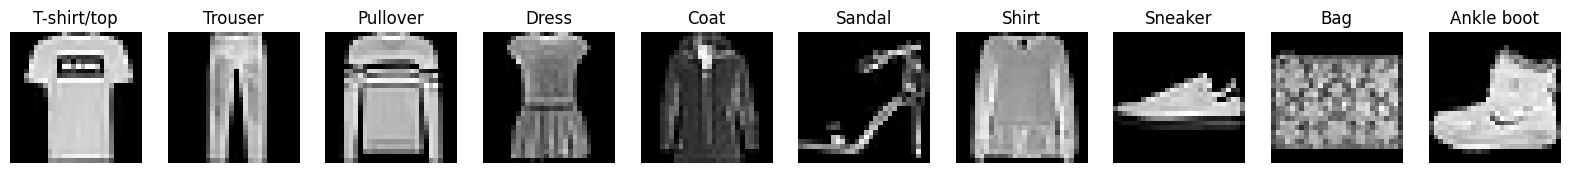

In [11]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist

# Initialize W&B
wandb.init(project="fashion-mnist-hyperparam-tuning")

# Load Fashion-MNIST dataset
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot 1 sample per class
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    axs[i].imshow(x_train[idx], cmap='gray')
    axs[i].set_title(class_names[i])
    axs[i].axis('off')

# Log the plot to W&B
wandb.log({"Fashion-MNIST Samples": wandb.Image(fig)})

# Show the plot
plt.show()


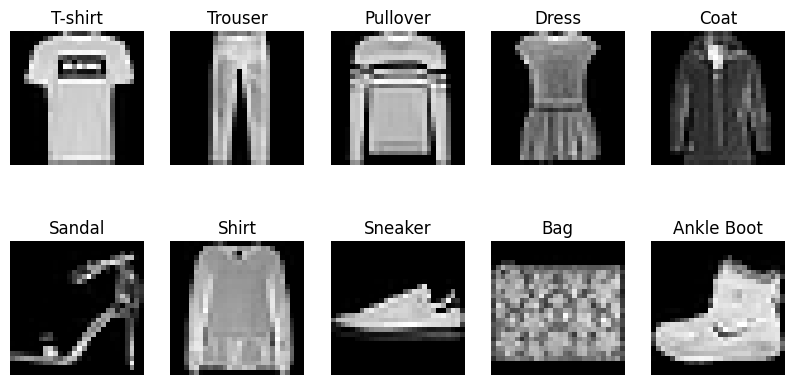

In [12]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Initialize wandb run
wandb.init(project="fashion-mnist-hyperparam-tuning", name="fashion-mnist-sample-images")

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

# Class names
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Create a W&B Table
table = wandb.Table(columns=["Image", "Class"])

# Plot one sample per class
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    index = np.where(y_train == i)[0][0]
    img = x_train[index]
    
    # Add image to wandb table
    table.add_data(wandb.Image(img), class_names[i])

    # Display in matplotlib
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(class_names[i])
    axes[i].axis("off")

plt.show()

# Log the table to wandb
wandb.log({"Fashion-MNIST Samples": table})

# Finish the wandb run
wandb.finish()


In [13]:
import wandb
import numpy as np
from keras.datasets import fashion_mnist

def train_model():
    run = wandb.init()
    config = run.config

    # Meaningful name for the sweep
    sweep_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_opt_{config.optimizer}"
    run.name = sweep_name

    # Prepare dataset (Fashion-MNIST)
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Convert labels to one-hot encoding
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # Split training into train and validation sets (90%-10%)
    val_split = int(0.9 * len(X_train))
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    # Initialize the neural network
    nn = NeuralNetwork(
        layer_sizes=[784] + [config.hidden_size] * config.hidden_layers + [10],
        learning_rate=config.learning_rate,
        optimizer=config.optimizer
    )

    # Training loop
    for epoch in range(config.epochs):
        loss = nn.train(X_train.T, y_train.T, epochs=1, batch_size=config.batch_size)
        val_pred = nn.forward_propagation(X_val.T)[0][len(nn.layer_sizes) - 1]
        val_loss = nn.compute_loss(y_val.T, val_pred)

        # Compute accuracy
        y_pred_train = np.argmax(nn.forward_propagation(X_train.T)[0][len(nn.layer_sizes) - 1], axis=0)
        y_true_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(y_pred_train == y_true_train) * 100  # Convert to percentage

        y_pred_val = np.argmax(val_pred, axis=0)
        y_true_val = np.argmax(y_val, axis=1)
        val_accuracy = np.mean(y_pred_val == y_true_val) * 100  # Convert to percentage

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "loss": loss,
            "accuracy": accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

    run.finish()
wandb.agent(sweep_id, function=train_model, count=20)

wandb: Agent Starting Run: 07rkrjju with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027
Epoch 1/1, Loss: 2.3027


accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▄▃▂▁
accuracy,9.9963
epoch,10
val_accuracy,10.03333
val_loss,2.30297


wandb: Agent Starting Run: ca0wkyn6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.3026
Epoch 1/1, Loss: 2.3001
Epoch 1/1, Loss: 2.1423
Epoch 1/1, Loss: 1.8736
Epoch 1/1, Loss: 1.7634
Epoch 1/1, Loss: 1.7190
Epoch 1/1, Loss: 1.6982
Epoch 1/1, Loss: 1.6872
Epoch 1/1, Loss: 1.6806
Epoch 1/1, Loss: 1.6753


accuracy,▁▁▇▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▇▇▇▇▇▇██
val_loss,██▆▃▂▁▁▁▁▁
accuracy,21.18889
epoch,10
val_accuracy,20.1
val_loss,1.67792


wandb: Agent Starting Run: 1f8nx1v8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.0424
Epoch 1/1, Loss: 0.7790
Epoch 1/1, Loss: 0.6904
Epoch 1/1, Loss: 0.6095
Epoch 1/1, Loss: 0.5444
Epoch 1/1, Loss: 0.5059
Epoch 1/1, Loss: 0.4754
Epoch 1/1, Loss: 0.4493
Epoch 1/1, Loss: 0.4278
Epoch 1/1, Loss: 0.4107


accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,86.47222
epoch,10
val_accuracy,85.28333
val_loss,0.44929


wandb: Agent Starting Run: ytvales1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.1468
Epoch 1/1, Loss: 0.8553
Epoch 1/1, Loss: 0.7008
Epoch 1/1, Loss: 0.5971
Epoch 1/1, Loss: 0.5389
Epoch 1/1, Loss: 0.4993
Epoch 1/1, Loss: 0.4694
Epoch 1/1, Loss: 0.4431
Epoch 1/1, Loss: 0.4143
Epoch 1/1, Loss: 0.3871


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,86.77222
epoch,10
val_accuracy,85.03333
val_loss,0.42965


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v0vy8dyj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.0167
Epoch 1/1, Loss: 1.9310
Epoch 1/1, Loss: 1.8733
Epoch 1/1, Loss: 1.8332
Epoch 1/1, Loss: 1.8037
Epoch 1/1, Loss: 1.7816
Epoch 1/1, Loss: 1.7643
Epoch 1/1, Loss: 1.7502
Epoch 1/1, Loss: 1.7379
Epoch 1/1, Loss: 1.7274


accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▇▇▇▇▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
accuracy,20.85926
epoch,10
val_accuracy,19.75
val_loss,1.73111


wandb: Agent Starting Run: gtv0dvbo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 2.2767
Epoch 1/1, Loss: 1.9937
Epoch 1/1, Loss: 1.8042
Epoch 1/1, Loss: 1.7333
Epoch 1/1, Loss: 1.7024
Epoch 1/1, Loss: 1.6855
Epoch 1/1, Loss: 1.6690
Epoch 1/1, Loss: 1.6171
Epoch 1/1, Loss: 1.5681
Epoch 1/1, Loss: 1.5266


accuracy,▁▁▂▂▂▂▃▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▂▁▁▁▂▃▆▇█
val_loss,█▅▄▃▃▂▂▂▁▁
accuracy,39.05741
epoch,10
val_accuracy,38.35
val_loss,1.52856


wandb: Agent Starting Run: xpyu285p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.8247
Epoch 1/1, Loss: 1.6970
Epoch 1/1, Loss: 1.6707
Epoch 1/1, Loss: 1.5465
Epoch 1/1, Loss: 1.4056
Epoch 1/1, Loss: 1.3203
Epoch 1/1, Loss: 1.2548
Epoch 1/1, Loss: 1.2047
Epoch 1/1, Loss: 1.1643
Epoch 1/1, Loss: 1.1275


accuracy,▁▁▂▅▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▂▅▅▆▇▇██
val_loss,█▇▆▅▄▃▂▂▁▁
accuracy,53.34815
epoch,10
val_accuracy,53.73333
val_loss,1.12387


wandb: Agent Starting Run: g33q6n1r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.8440
Epoch 1/1, Loss: 1.7017
Epoch 1/1, Loss: 1.6756
Epoch 1/1, Loss: 1.6046
Epoch 1/1, Loss: 1.4980
Epoch 1/1, Loss: 1.3796
Epoch 1/1, Loss: 1.3052
Epoch 1/1, Loss: 1.2464
Epoch 1/1, Loss: 1.2010
Epoch 1/1, Loss: 1.1649


accuracy,▁▁▂▄▅▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▂▄▅▅▆▇██
val_loss,█▇▆▆▄▃▂▂▁▁
accuracy,51.22593
epoch,10
val_accuracy,51.43333
val_loss,1.1617


wandb: Agent Starting Run: kj7q9rl4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.6965
Epoch 1/1, Loss: 1.6350
Epoch 1/1, Loss: 1.3341
Epoch 1/1, Loss: 1.2088
Epoch 1/1, Loss: 1.1173
Epoch 1/1, Loss: 1.0311
Epoch 1/1, Loss: 0.9640
Epoch 1/1, Loss: 0.9182
Epoch 1/1, Loss: 0.8843
Epoch 1/1, Loss: 0.8554


accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▇▅▄▃▂▂▂▁▁
accuracy,66.35
epoch,10
val_accuracy,66.95
val_loss,0.85449


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z6egw57z with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.6927
Epoch 1/1, Loss: 1.5776
Epoch 1/1, Loss: 1.3340
Epoch 1/1, Loss: 1.2050
Epoch 1/1, Loss: 1.1058
Epoch 1/1, Loss: 1.0193
Epoch 1/1, Loss: 0.9570
Epoch 1/1, Loss: 0.9143
Epoch 1/1, Loss: 0.8815
Epoch 1/1, Loss: 0.8526


accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▃▄▅▇▇▇███
val_loss,█▇▅▄▃▂▂▂▁▁
accuracy,66.91667
epoch,10
val_accuracy,67.51667
val_loss,0.85083


wandb: Agent Starting Run: dln331kr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.0349
Epoch 1/1, Loss: 0.8139
Epoch 1/1, Loss: 0.6075
Epoch 1/1, Loss: 0.5039
Epoch 1/1, Loss: 0.4406
Epoch 1/1, Loss: 0.4022
Epoch 1/1, Loss: 0.3776
Epoch 1/1, Loss: 0.3595
Epoch 1/1, Loss: 0.3454
Epoch 1/1, Loss: 0.3339


accuracy,▁▃▅▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▂▂▂▁▁▁▁
accuracy,88.35741
epoch,10
val_accuracy,87.06667
val_loss,0.37866


wandb: Agent Starting Run: a3gmk95a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.0742
Epoch 1/1, Loss: 0.9391
Epoch 1/1, Loss: 0.6717
Epoch 1/1, Loss: 0.5410
Epoch 1/1, Loss: 0.4725
Epoch 1/1, Loss: 0.4310
Epoch 1/1, Loss: 0.4012
Epoch 1/1, Loss: 0.3784
Epoch 1/1, Loss: 0.3602
Epoch 1/1, Loss: 0.3453


accuracy,▁▂▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▂▆▇▇▇████
val_loss,█▇▄▃▂▂▁▁▁▁
accuracy,88.14074
epoch,10
val_accuracy,86.43333
val_loss,0.38909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ydc32eae with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.4098
Epoch 1/1, Loss: 1.0948
Epoch 1/1, Loss: 0.9939
Epoch 1/1, Loss: 0.9345
Epoch 1/1, Loss: 0.8358
Epoch 1/1, Loss: 0.7642
Epoch 1/1, Loss: 0.7057
Epoch 1/1, Loss: 0.6536
Epoch 1/1, Loss: 0.6030
Epoch 1/1, Loss: 0.5530


accuracy,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▅▅▄▃▃▂▂▁▁
accuracy,80.72222
epoch,10
val_accuracy,80.06667
val_loss,0.57556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oy5gmi14 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.8129
Epoch 1/1, Loss: 1.6942
Epoch 1/1, Loss: 1.6722
Epoch 1/1, Loss: 1.5973
Epoch 1/1, Loss: 1.4478
Epoch 1/1, Loss: 1.3522
Epoch 1/1, Loss: 1.2828
Epoch 1/1, Loss: 1.2272
Epoch 1/1, Loss: 1.1817
Epoch 1/1, Loss: 1.1420


accuracy,▁▁▂▅▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▂▅▅▆▇▇██
val_loss,█▇▇▆▄▃▂▂▁▁
accuracy,52.43519
epoch,10
val_accuracy,52.61667
val_loss,1.13869


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zwsj469s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.0206
Epoch 1/1, Loss: 0.7211
Epoch 1/1, Loss: 0.5803
Epoch 1/1, Loss: 0.5036
Epoch 1/1, Loss: 0.4513
Epoch 1/1, Loss: 0.4150
Epoch 1/1, Loss: 0.3893
Epoch 1/1, Loss: 0.3696
Epoch 1/1, Loss: 0.3533
Epoch 1/1, Loss: 0.3395


accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
accuracy,88.23333
epoch,10
val_accuracy,86.31667
val_loss,0.38989


wandb: Agent Starting Run: z0lsvd22 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 0.8818
Epoch 1/1, Loss: 0.6104
Epoch 1/1, Loss: 0.5024
Epoch 1/1, Loss: 0.4317
Epoch 1/1, Loss: 0.3945
Epoch 1/1, Loss: 0.3682
Epoch 1/1, Loss: 0.3472
Epoch 1/1, Loss: 0.3303
Epoch 1/1, Loss: 0.3159
Epoch 1/1, Loss: 0.3033


accuracy,▁▃▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,89.41111
epoch,10
val_accuracy,87.63333
val_loss,0.36283


wandb: Agent Starting Run: vaiceqaw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.0830
Epoch 1/1, Loss: 0.8272
Epoch 1/1, Loss: 0.7058
Epoch 1/1, Loss: 0.6434
Epoch 1/1, Loss: 0.5866
Epoch 1/1, Loss: 0.5269
Epoch 1/1, Loss: 0.4835
Epoch 1/1, Loss: 0.4349
Epoch 1/1, Loss: 0.4002
Epoch 1/1, Loss: 0.3748


accuracy,▁▃▅▅▆▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▃▅▅▆▇▇███
val_loss,█▅▄▄▃▂▂▂▁▁
accuracy,87.36852
epoch,10
val_accuracy,85.91667
val_loss,0.41427


wandb: Agent Starting Run: 965qufkk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.5246
Epoch 1/1, Loss: 1.0794
Epoch 1/1, Loss: 0.7686
Epoch 1/1, Loss: 0.6348
Epoch 1/1, Loss: 0.5689
Epoch 1/1, Loss: 0.5279
Epoch 1/1, Loss: 0.4946
Epoch 1/1, Loss: 0.4571
Epoch 1/1, Loss: 0.4302
Epoch 1/1, Loss: 0.4086


accuracy,▁▄▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▂▂▁▁▁
accuracy,86.01296
epoch,10
val_accuracy,84.6
val_loss,0.44192


wandb: Agent Starting Run: wjnruv73 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 1.7035
Epoch 1/1, Loss: 1.6631
Epoch 1/1, Loss: 1.4088
Epoch 1/1, Loss: 1.2590
Epoch 1/1, Loss: 1.1689
Epoch 1/1, Loss: 1.0911
Epoch 1/1, Loss: 1.0179
Epoch 1/1, Loss: 0.9607
Epoch 1/1, Loss: 0.9201
Epoch 1/1, Loss: 0.8894


accuracy,▁▂▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▂▄▅▆▇▇███
val_loss,██▅▄▃▃▂▂▁▁
accuracy,64.25185
epoch,10
val_accuracy,65.2
val_loss,0.88954


wandb: Agent Starting Run: y9rhnyik with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/1, Loss: 0.6637
Epoch 1/1, Loss: 0.4926
Epoch 1/1, Loss: 0.4207
Epoch 1/1, Loss: 0.3810
Epoch 1/1, Loss: 0.3547
Epoch 1/1, Loss: 0.3346
Epoch 1/1, Loss: 0.3193
Epoch 1/1, Loss: 0.3069
Epoch 1/1, Loss: 0.2963
Epoch 1/1, Loss: 0.2868


accuracy,▁▅▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,89.78519
epoch,10
val_accuracy,87.93333
val_loss,0.34656


In [24]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, optimizer="sgd", weight_init="random", weight_decay=0.0):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.weight_decay = weight_decay  # Added weight_decay

        self.initialize_weights()
        self.initialize_optimizer_cache()

    def initialize_weights(self):
        self.weights = {}
        self.biases = {}

        for i in range(1, len(self.layer_sizes)):
            self.weights[i] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * 0.01
            self.biases[i] = np.zeros((self.layer_sizes[i], 1))

    def initialize_optimizer_cache(self):
        self.v = {i: np.zeros_like(w) for i, w in self.weights.items()}  # Momentum
        self.s = {i: np.zeros_like(w) for i, w in self.weights.items()}  # RMSprop

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def forward_propagation(self, X):
        activations = {0: X}
        zs = {}

        for i in range(1, len(self.layer_sizes)):
            zs[i] = np.dot(self.weights[i], activations[i - 1]) + self.biases[i]
            if i == len(self.layer_sizes) - 1:
                activations[i] = self.softmax(zs[i])
            else:
                activations[i] = self.sigmoid(zs[i])

        return activations, zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward_propagation(self, activations, zs, y_true):
        m = y_true.shape[1]
        grads = {}

        dz = activations[len(self.layer_sizes) - 1] - y_true
        for i in reversed(range(1, len(self.layer_sizes))):
            grads[f'dW{i}'] = np.dot(dz, activations[i - 1].T) / m
            grads[f'db{i}'] = np.sum(dz, axis=1, keepdims=True) / m
            if i > 1:
                dz = np.dot(self.weights[i].T, dz) * activations[i - 1] * (1 - activations[i - 1])

        return grads

    def update_weights(self, grads, t=1):
        for i in range(1, len(self.layer_sizes)):
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * grads[f'dW{i}']
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "momentum":
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nesterov":
                v_prev = self.v[i]
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= 0.9 * v_prev + (1 + 0.9) * self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "rmsprop":
                self.s[i] = 0.9 * self.s[i] + 0.1 * grads[f'dW{i}']**2
                self.weights[i] -= self.learning_rate * grads[f'dW{i}'] / (np.sqrt(self.s[i]) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "adam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                self.weights[i] -= self.learning_rate * v_corrected / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nadam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                m_hat = beta1 * v_corrected + (1 - beta1) * grads[f'dW{i}']
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

    def train(self, X, y, epochs=10, batch_size=32):
        m = X.shape[1]
        for epoch in range(epochs):
            for i in range(0, m, batch_size):
                X_batch = X[:, i:i+batch_size]
                y_batch = y[:, i:i+batch_size]

                activations, zs = self.forward_propagation(X_batch)
                grads = self.backward_propagation(activations, zs, y_batch)
                self.update_weights(grads, epoch+1)

            loss = self.compute_loss(y, self.forward_propagation(X)[0][len(self.layer_sizes) - 1])
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


Test Accuracy: 10.00%


C:\Users\ashuy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ashuy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ashuy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

test_accuracy,▁
test_accuracy,10


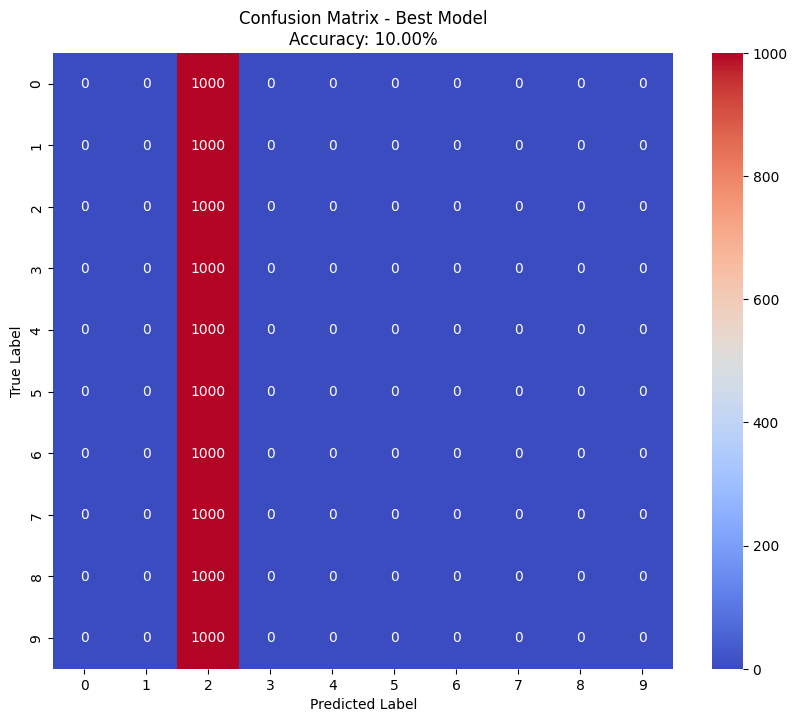

In [6]:
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, classification_report

# Ensure you have the correct NeuralNetwork class definition before running this

# Evaluation Function
def evaluate_best_model():
    
    # Start new W&B session
    run = wandb.init(project="fashion-mnist-hyperparam-tuning", name="best1")

    # Best model hyperparameters
    best_config = {
        "hidden_layers": 3,
        "hidden_size": 128,
        "activation": "relu",
        "optimizer": "adam",
        "learning_rate": 0.001,
        "batch_size": 16,
        "weight_decay": 0.5,
        "weight_init": "xavier"
    }

    # Load dataset
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_test = X_test / 255.0  # Normalize pixel values
    X_test = X_test.reshape(X_test.shape[0], -1).T  # Flatten and transpose for NN

    # Initialize the trained model
    nn = NeuralNetwork(
        layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
        learning_rate=best_config["learning_rate"],
        optimizer=best_config["optimizer"],
        weight_init=best_config["weight_init"],
        weight_decay=best_config["weight_decay"]
    )

    # Perform forward propagation
    activations, _ = nn.forward_propagation(X_test)  # Extract activations only
    test_logits = activations[len(nn.layer_sizes) - 1]  # Final layer output
    test_predictions = np.argmax(test_logits, axis=0)  # Get class predictions

    # Compute accuracy
    test_accuracy = np.mean(test_predictions == y_test) * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Log test accuracy
    wandb.log({"test_accuracy": test_accuracy})

    # Compute Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)

    # Enhanced Confusion Matrix Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Best Model\nAccuracy: {test_accuracy:.2f}%")

    # Save and log the plot
    plt.savefig("confusion_matrix.png")
    wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix.png")})

    # Classification Report
    class_report = classification_report(y_test, test_predictions, output_dict=True)
    wandb.log({"classification_report": class_report})

    # Finish W&B run
    run.finish()

# Run the evaluation
evaluate_best_model()


## Question 7
For the best model identified above, report the accuracy on the test set of fashion_ mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is).

Epoch 1/10, Loss: 0.6384
Epoch 2/10, Loss: 0.4914
Epoch 3/10, Loss: 0.4312
Epoch 4/10, Loss: 0.4028
Epoch 5/10, Loss: 0.3830
Epoch 6/10, Loss: 0.3673
Epoch 7/10, Loss: 0.3540
Epoch 8/10, Loss: 0.3426
Epoch 9/10, Loss: 0.3327
Epoch 10/10, Loss: 0.3241


✅ Test Accuracy: 86.29%


test_accuracy,▁
test_accuracy,86.29


✅ Evaluation complete. Confusion matrix and metrics logged.


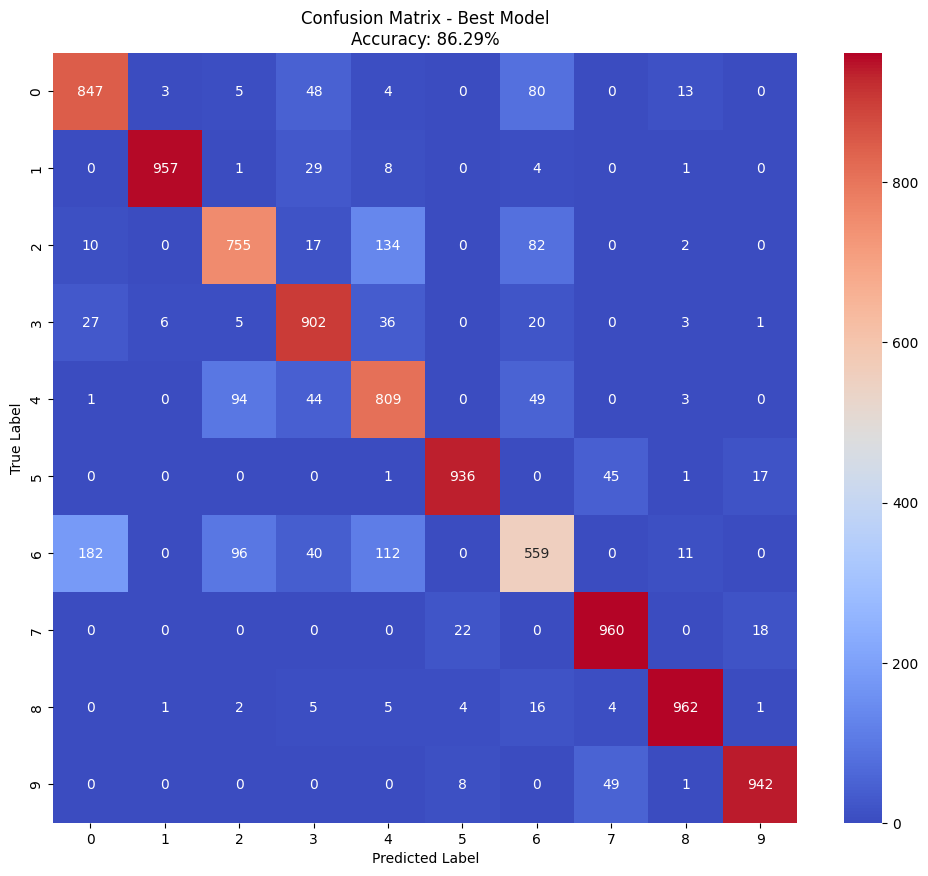

In [9]:
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, classification_report

# Initialize Weights & Biases
wandb.init(project="fashion-mnist-hyperparam-tuning", name="best_model_train")

# Best Model Hyperparameters
best_config = {
    "hidden_layers": 3,
    "hidden_size": 128,
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "batch_size": 16,
    "epochs": 10,
    "weight_decay": 0.5,
    "weight_init": "xavier"
}

# Load Dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize & Reshape
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (60000, 784)
X_test = X_test.reshape(X_test.shape[0], -1)  # Flatten to (10000, 784)

# One-hot encode labels
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train].T  # Shape (10, 60000)
y_test_one_hot = np.eye(num_classes)[y_test].T  # Shape (10, 10000)

# Initialize Model
nn = NeuralNetwork(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

# Train the Model
nn.train(X_train.T, y_train_one_hot, epochs=best_config["epochs"], batch_size=best_config["batch_size"])

# --- Evaluation ---
wandb.finish()
wandb.init(project="fashion-mnist-hyperparam-tuning", name="best_model_eval")

# Evaluate on Test Set
activations, _ = nn.forward_propagation(X_test.T)
test_logits = activations[len(nn.layer_sizes) - 1]  # Final layer activations (probabilities)
test_predictions = np.argmax(test_logits, axis=0)  # Get class predictions
test_accuracy = np.mean(test_predictions == y_test) * 100

# Log Test Accuracy
wandb.log({"test_accuracy": test_accuracy})
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)

# Enhanced Confusion Matrix Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Best Model\nAccuracy: {test_accuracy:.2f}%")

# Save and Log Plot
plt.savefig("confusion_matrix.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix.png")})

# Classification Report
class_report = classification_report(y_test, test_predictions, output_dict=True)
wandb.log({"classification_report": class_report})

wandb.finish()
print("✅ Evaluation complete. Confusion matrix and metrics logged.")


Epoch 1/10, Loss: 1.7852
Epoch 2/10, Loss: 1.3566
Epoch 3/10, Loss: 1.2091
Epoch 4/10, Loss: 1.1260
Epoch 5/10, Loss: 1.0794
Epoch 6/10, Loss: 1.0486
Epoch 7/10, Loss: 1.0248
Epoch 8/10, Loss: 1.0035
Epoch 9/10, Loss: 0.9799
Epoch 10/10, Loss: 0.9575
Epoch 1/10, Loss: 0.0653
Epoch 2/10, Loss: 0.0583
Epoch 3/10, Loss: 0.0541
Epoch 4/10, Loss: 0.0502
Epoch 5/10, Loss: 0.0465
Epoch 6/10, Loss: 0.0441
Epoch 7/10, Loss: 0.0425
Epoch 8/10, Loss: 0.0413
Epoch 9/10, Loss: 0.0405
Epoch 10/10, Loss: 0.0398


Cross-Entropy_test_accuracy,▁
Cross_Entropy_Accuracy,▁
Squared Error_test_accuracy,▁
Squared_Error_Accuracy,▁
Cross-Entropy_test_accuracy,59.81
Cross_Entropy_Accuracy,59.81
Squared Error_test_accuracy,65.13
Squared_Error_Accuracy,65.13


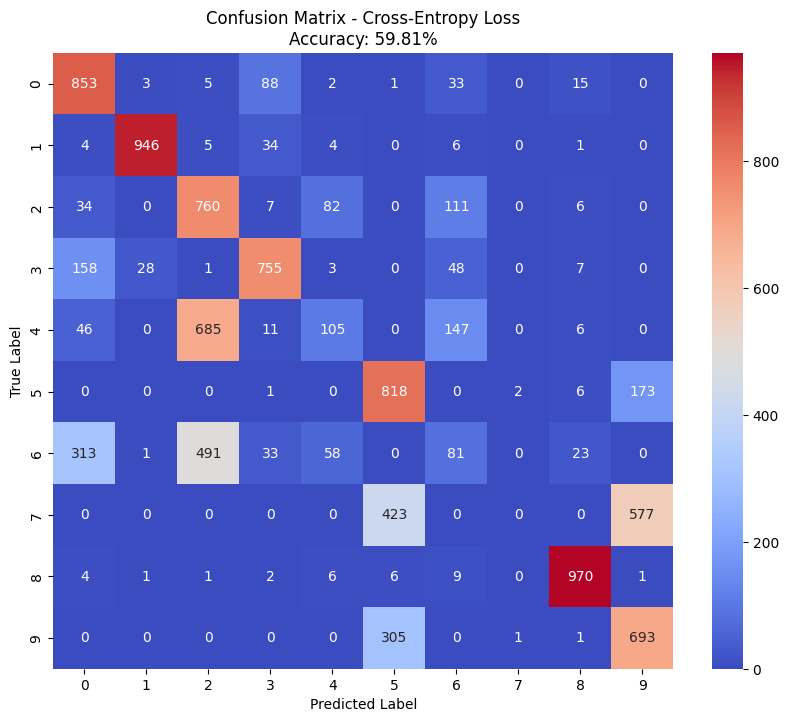

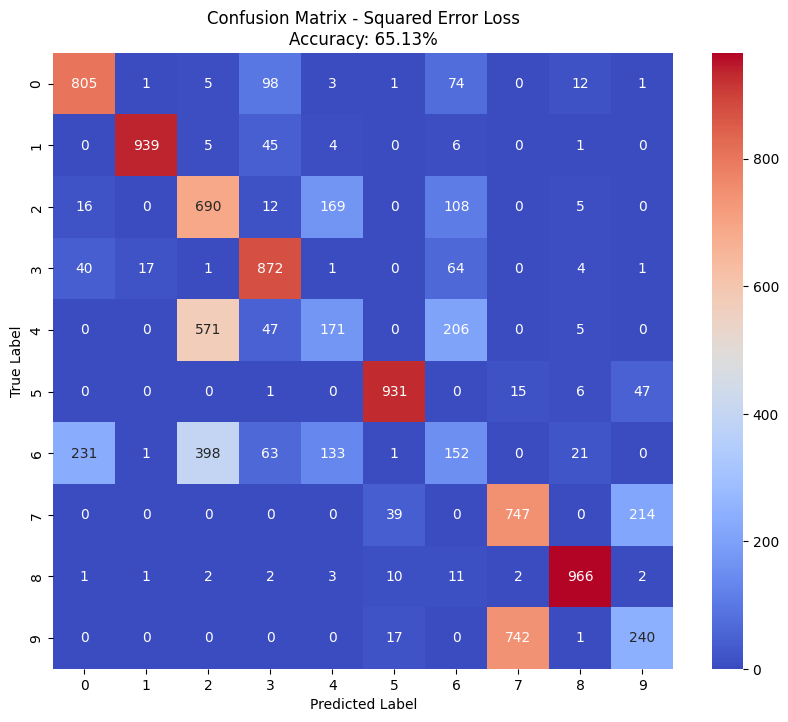

In [11]:
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, classification_report

# Function to evaluate the model
def evaluate_model(model, X_test, y_test, loss_name):
    activations, _ = model.forward_propagation(X_test)
    test_logits = activations[len(model.layer_sizes) - 1]
    test_predictions = np.argmax(test_logits, axis=0)
    test_accuracy = np.mean(test_predictions == y_test) * 100
    
    # Log test accuracy
    wandb.log({f"{loss_name}_test_accuracy": test_accuracy})
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {loss_name} Loss\nAccuracy: {test_accuracy:.2f}%")
    plt.savefig(f"confusion_matrix_{loss_name}.png")
    wandb.log({f"{loss_name}_Confusion Matrix": wandb.Image(f"confusion_matrix_{loss_name}.png")})
    
    # Classification Report
    class_report = classification_report(y_test, test_predictions, output_dict=True)
    wandb.log({f"{loss_name}_classification_report": class_report})
    
    return test_accuracy

# Initialize W&B
wandb.init(project="fashion-mnist-hyperparam-tuning", name="cross_entropy_vs_squared_error")



# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_test = X_test / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).T
y_test_one_hot = np.eye(10)[y_test].T  # One-hot encoding

# Model configurations
best_config = {
    "hidden_layers": 3,
    "hidden_size": 128,
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "batch_size": 16,
    "weight_decay": 0.5,
    "weight_init": "xavier",
    "epochs": 10
}

# Model with Cross-Entropy Loss
class CrossEntropyModel(NeuralNetwork):
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

# Model with Squared Error Loss
class SquaredErrorModel(NeuralNetwork):
    def compute_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

# Initialize models
ce_model = CrossEntropyModel(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

se_model = SquaredErrorModel(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

# Train both models
ce_model.train(X_test, y_test_one_hot, epochs=best_config["epochs"], batch_size=best_config["batch_size"])
se_model.train(X_test, y_test_one_hot, epochs=best_config["epochs"], batch_size=best_config["batch_size"])

# Evaluate both models
ce_accuracy = evaluate_model(ce_model, X_test, y_test, "Cross-Entropy")
se_accuracy = evaluate_model(se_model, X_test, y_test, "Squared Error")

# Log final accuracies
wandb.log({"Cross_Entropy_Accuracy": ce_accuracy, "Squared_Error_Accuracy": se_accuracy})

# Finish W&B run
wandb.finish()


Epoch 1/10, Loss: 1.5424
Epoch 2/10, Loss: 1.2073
Epoch 3/10, Loss: 1.0949
Epoch 4/10, Loss: 1.0348
Epoch 5/10, Loss: 0.9876
Epoch 6/10, Loss: 0.9375
Epoch 7/10, Loss: 0.8834
Epoch 8/10, Loss: 0.8391
Epoch 9/10, Loss: 0.7987
Epoch 10/10, Loss: 0.7681
Epoch 1/10, Loss: 0.0608
Epoch 2/10, Loss: 0.0550
Epoch 3/10, Loss: 0.0510
Epoch 4/10, Loss: 0.0464
Epoch 5/10, Loss: 0.0436
Epoch 6/10, Loss: 0.0413
Epoch 7/10, Loss: 0.0391
Epoch 8/10, Loss: 0.0373
Epoch 9/10, Loss: 0.0359
Epoch 10/10, Loss: 0.0347


Cross-Entropy_test_accuracy,▁
Cross_Entropy_Accuracy,▁
Squared Error_test_accuracy,▁
Squared_Error_Accuracy,▁
Cross-Entropy_test_accuracy,66
Cross_Entropy_Accuracy,66
Squared Error_test_accuracy,72.62
Squared_Error_Accuracy,72.62


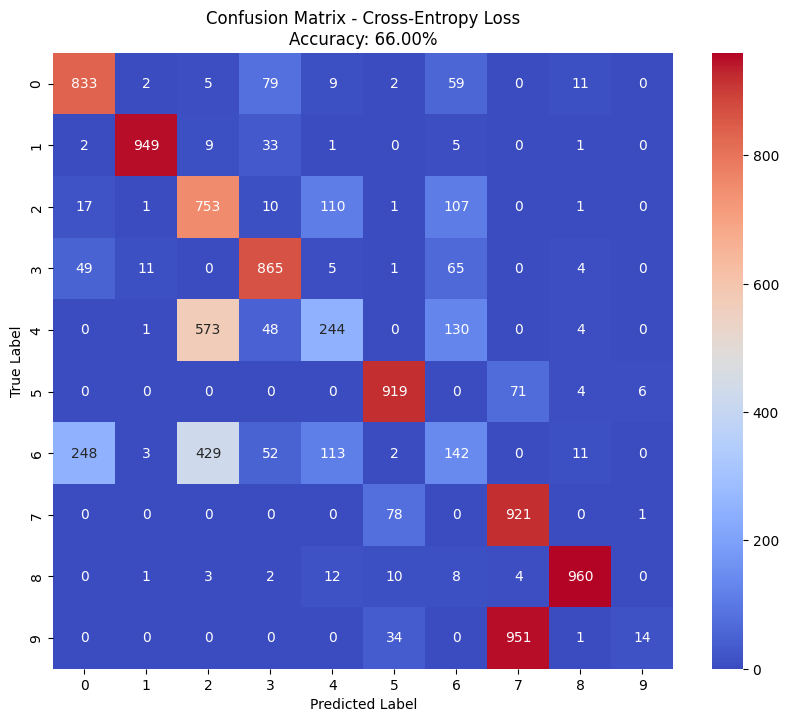

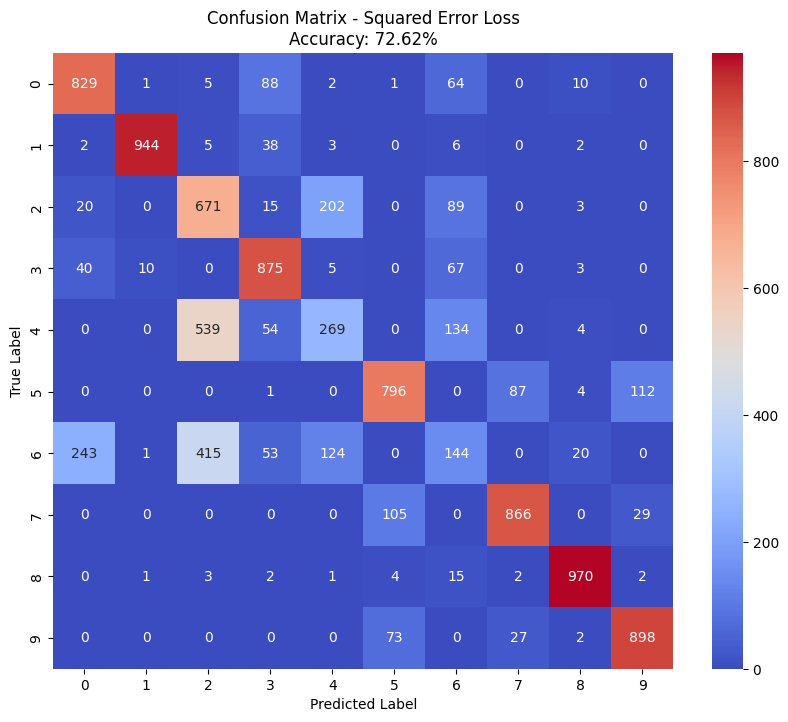

In [13]:
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, classification_report

# Initialize W&B
wandb.init(project="fashion-mnist-hyperparam-tuning", name="cross_entropy_vs_squared_error")

# Log Hyperparameters
best_config = {
    "hidden_layers": 3,
    "hidden_size": 128,
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "batch_size": 16,
    "weight_decay": 0.5,
    "weight_init": "xavier",
    "epochs": 10
}
wandb.config.update(best_config)

# Function to evaluate the model
def evaluate_model(model, X_test, y_test, loss_name):
    activations, _ = model.forward_propagation(X_test)
    test_logits = activations[len(model.layer_sizes) - 1]
    test_predictions = np.argmax(test_logits, axis=0)
    test_accuracy = np.mean(test_predictions == y_test) * 100
    
    # Log test accuracy
    wandb.log({f"{loss_name}_test_accuracy": test_accuracy})
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {loss_name} Loss\nAccuracy: {test_accuracy:.2f}%")
    plt.savefig(f"confusion_matrix_{loss_name}.png")
    wandb.log({f"{loss_name}_Confusion Matrix": wandb.Image(f"confusion_matrix_{loss_name}.png")})
    
    # Classification Report
    class_report = classification_report(y_test, test_predictions, output_dict=True)
    wandb.log({f"{loss_name}_classification_report": class_report})
    
    return test_accuracy

# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_test = X_test / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).T
y_test_one_hot = np.eye(10)[y_test].T  # One-hot encoding

# Model with Cross-Entropy Loss
class CrossEntropyModel(NeuralNetwork):
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

# Model with Squared Error Loss
class SquaredErrorModel(NeuralNetwork):
    def compute_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

# Initialize models
ce_model = CrossEntropyModel(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

se_model = SquaredErrorModel(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

# Train both models
ce_model.train(X_test, y_test_one_hot, epochs=best_config["epochs"], batch_size=best_config["batch_size"])
se_model.train(X_test, y_test_one_hot, epochs=best_config["epochs"], batch_size=best_config["batch_size"])

# Evaluate both models
ce_accuracy = evaluate_model(ce_model, X_test, y_test, "Cross-Entropy")
se_accuracy = evaluate_model(se_model, X_test, y_test, "Squared Error")

# Log final accuracies
wandb.log({"Cross_Entropy_Accuracy": ce_accuracy, "Squared_Error_Accuracy": se_accuracy})

# Finish W&B run
wandb.finish()


In [14]:
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix, classification_report

# Initialize wandb
wandb.init(project="fashion-mnist-loss-comparison", name="crossentropy_vs_mse")

# Hyperparameters
best_config = {
    "hidden_layers": 3,
    "hidden_size": 128,
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "batch_size": 16,
    "epochs": 10,
    "weight_decay": 0.5,
    "weight_init": "xavier"
}

# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize
X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

# Convert labels to one-hot encoding
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

# Define loss functions
def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / y_true.shape[0]

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Train two models (one with Cross-Entropy, one with MSE)
nn_ce = NeuralNetwork(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

nn_mse = NeuralNetwork(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

# Training loop
loss_ce_list, loss_mse_list = [], []

for epoch in range(best_config["epochs"]):
    activations_ce, _ = nn_ce.forward_propagation(X_train.T)
    activations_mse, _ = nn_mse.forward_propagation(X_train.T)

    loss_ce = cross_entropy_loss(y_train_onehot, activations_ce[len(nn_ce.layer_sizes) - 1].T)
    loss_mse = mse_loss(y_train_onehot, activations_mse[len(nn_mse.layer_sizes) - 1].T)

    loss_ce_list.append(loss_ce)
    loss_mse_list.append(loss_mse)

    # Backpropagation
    grads_ce = nn_ce.backward_propagation(activations_ce, _, y_train_onehot.T)
    grads_mse = nn_mse.backward_propagation(activations_mse, _, y_train_onehot.T)

    nn_ce.update_weights(grads_ce, epoch + 1)
    nn_mse.update_weights(grads_mse, epoch + 1)

    # Log losses
    wandb.log({"Cross Entropy Loss": loss_ce, "MSE Loss": loss_mse})

# Evaluate on test set
activations_ce, _ = nn_ce.forward_propagation(X_test.T)
activations_mse, _ = nn_mse.forward_propagation(X_test.T)

test_logits_ce = activations_ce[len(nn_ce.layer_sizes) - 1]
test_logits_mse = activations_mse[len(nn_mse.layer_sizes) - 1]

test_predictions_ce = np.argmax(test_logits_ce, axis=0)
test_predictions_mse = np.argmax(test_logits_mse, axis=0)

test_accuracy_ce = np.mean(test_predictions_ce == y_test) * 100
test_accuracy_mse = np.mean(test_predictions_mse == y_test) * 100

wandb.log({"Test Accuracy - CE": test_accuracy_ce, "Test Accuracy - MSE": test_accuracy_mse})

# Confusion Matrices
cm_ce = confusion_matrix(y_test, test_predictions_ce)
cm_mse = confusion_matrix(y_test, test_predictions_mse)

# Log Probability Distributions
wandb.log({
    "Probability Distribution - CE": wandb.Histogram(test_logits_ce.flatten()),
    "Probability Distribution - MSE": wandb.Histogram(test_logits_mse.flatten())
})

# Classification Reports
class_report_ce = classification_report(y_test, test_predictions_ce, output_dict=True)
class_report_mse = classification_report(y_test, test_predictions_mse, output_dict=True)

wandb.log({"Classification Report - CE": class_report_ce})
wandb.log({"Classification Report - MSE": class_report_mse})

# Finish wandb run
wandb.finish()


C:\Users\ashuy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ashuy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ashuy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Cross Entropy Loss,█▇▅▆▅▃▂▂▂▁
MSE Loss,█▅▄▅▄▃▂▂▁▁
Test Accuracy - CE,▁
Test Accuracy - MSE,▁
Cross Entropy Loss,2.30238
MSE Loss,0.09
Test Accuracy - CE,10
Test Accuracy - MSE,10


In [15]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist

# Initialize W&B
wandb.init(project="fashion-mnist-hyperparam-tuning", name="cross_entropy_vs_squared_error")

# Log Best Hyperparameters
best_config = {
    "hidden_layers": 3,
    "hidden_size": 128,
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "batch_size": 16,
    "weight_decay": 0.5,
    "weight_init": "xavier",
    "epochs": 10
}
wandb.config.update(best_config)

# Load Dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

# Model with Cross-Entropy Loss
class CrossEntropyModel(NeuralNetwork):
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

# Model with Squared Error Loss
class SquaredErrorModel(NeuralNetwork):
    def compute_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

# Initialize Models
ce_model = CrossEntropyModel(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

se_model = SquaredErrorModel(
    layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
    learning_rate=best_config["learning_rate"],
    optimizer=best_config["optimizer"],
    weight_init=best_config["weight_init"],
    weight_decay=best_config["weight_decay"]
)

# Training Function
def train_and_log(model, X_train, y_train, X_val, y_val, loss_name):
    for epoch in range(best_config["epochs"]):
        loss = model.train(X_train.T, y_train.T, epochs=1, batch_size=best_config["batch_size"])
        val_pred = model.forward_propagation(X_val.T)[0][len(model.layer_sizes) - 1]
        val_loss = model.compute_loss(y_val.T, val_pred)

        # Accuracy
        y_pred_train = np.argmax(model.forward_propagation(X_train.T)[0][len(model.layer_sizes) - 1], axis=0)
        accuracy = np.mean(y_pred_train == np.argmax(y_train, axis=1)) * 100

        y_pred_val = np.argmax(val_pred, axis=0)
        val_accuracy = np.mean(y_pred_val == np.argmax(y_val, axis=1)) * 100

        # Log Metrics
        wandb.log({
            f"{loss_name}_loss": loss,
            f"{loss_name}_val_loss": val_loss,
            f"{loss_name}_accuracy": accuracy,
            f"{loss_name}_val_accuracy": val_accuracy,
            "epoch": epoch + 1
        })

# Split into Train & Validation
val_split = int(0.9 * len(X_train))
X_train, X_val = X_train[:val_split], X_train[val_split:]
y_train, y_val = y_train[:val_split], y_train[val_split:]

# Train Both Models
train_and_log(ce_model, X_train, y_train, X_val, y_val, "cross_entropy")
train_and_log(se_model, X_train, y_train, X_val, y_val, "squared_error")

# Finish W&B Run
wandb.finish()


Epoch 1/1, Loss: 0.6854
Epoch 1/1, Loss: 0.4967
Epoch 1/1, Loss: 0.4211
Epoch 1/1, Loss: 0.3851
Epoch 1/1, Loss: 0.3613
Epoch 1/1, Loss: 0.3434
Epoch 1/1, Loss: 0.3287
Epoch 1/1, Loss: 0.3158
Epoch 1/1, Loss: 0.3042
Epoch 1/1, Loss: 0.2936
Epoch 1/1, Loss: 0.0355
Epoch 1/1, Loss: 0.0280
Epoch 1/1, Loss: 0.0223
Epoch 1/1, Loss: 0.0200
Epoch 1/1, Loss: 0.0186
Epoch 1/1, Loss: 0.0176
Epoch 1/1, Loss: 0.0167
Epoch 1/1, Loss: 0.0160
Epoch 1/1, Loss: 0.0154
Epoch 1/1, Loss: 0.0149


cross_entropy_accuracy,▁▅▆▇▇▇████
cross_entropy_val_accuracy,▁▅▆▇▇▇████
cross_entropy_val_loss,█▄▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
squared_error_accuracy,▁▄▆▇▇▇████
squared_error_val_accuracy,▁▄▆▇▇▇████
squared_error_val_loss,█▅▃▂▂▂▁▁▁▁
cross_entropy_accuracy,89.64815
cross_entropy_val_accuracy,87.85
cross_entropy_val_loss,0.35123
epoch,10


In [25]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, optimizer="sgd", weight_init="random", weight_decay=0.0):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.weight_decay = weight_decay  # Added weight_decay

        self.initialize_weights()
        self.initialize_optimizer_cache()

    def initialize_weights(self):
        self.weights = {}
        self.biases = {}

        for i in range(1, len(self.layer_sizes)):
            self.weights[i] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * 0.01
            self.biases[i] = np.zeros((self.layer_sizes[i], 1))

    def initialize_optimizer_cache(self):
        self.v = {i: np.zeros_like(w) for i, w in self.weights.items()}  # Momentum
        self.s = {i: np.zeros_like(w) for i, w in self.weights.items()}  # RMSprop

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def forward_propagation(self, X):
        activations = {0: X}
        zs = {}

        for i in range(1, len(self.layer_sizes)):
            zs[i] = np.dot(self.weights[i], activations[i - 1]) + self.biases[i]
            if i == len(self.layer_sizes) - 1:
                activations[i] = self.softmax(zs[i])
            else:
                activations[i] = self.sigmoid(zs[i])

        return activations, zs

    def compute_loss(self, y_true, y_pred, loss_type="cross_entropy"):
        m = y_true.shape[1]
        if loss_type == "cross_entropy":
            return -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        elif loss_type == "mse":
            return np.sum((y_true - y_pred) ** 2) / (2 * m)


    def backward_propagation(self, activations, zs, y_true):
        m = y_true.shape[1]
        grads = {}

        dz = activations[len(self.layer_sizes) - 1] - y_true
        for i in reversed(range(1, len(self.layer_sizes))):
            grads[f'dW{i}'] = np.dot(dz, activations[i - 1].T) / m
            grads[f'db{i}'] = np.sum(dz, axis=1, keepdims=True) / m
            if i > 1:
                dz = np.dot(self.weights[i].T, dz) * activations[i - 1] * (1 - activations[i - 1])

        return grads

    def update_weights(self, grads, t=1):
        for i in range(1, len(self.layer_sizes)):
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * grads[f'dW{i}']
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "momentum":
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nesterov":
                v_prev = self.v[i]
                self.v[i] = 0.9 * self.v[i] + self.learning_rate * grads[f'dW{i}']
                self.weights[i] -= 0.9 * v_prev + (1 + 0.9) * self.v[i]
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "rmsprop":
                self.s[i] = 0.9 * self.s[i] + 0.1 * grads[f'dW{i}']**2
                self.weights[i] -= self.learning_rate * grads[f'dW{i}'] / (np.sqrt(self.s[i]) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "adam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                self.weights[i] -= self.learning_rate * v_corrected / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

            elif self.optimizer == "nadam":
                beta1, beta2 = 0.9, 0.999
                self.v[i] = beta1 * self.v[i] + (1 - beta1) * grads[f'dW{i}']
                self.s[i] = beta2 * self.s[i] + (1 - beta2) * grads[f'dW{i}']**2

                v_corrected = self.v[i] / (1 - beta1**t)
                s_corrected = self.s[i] / (1 - beta2**t)

                m_hat = beta1 * v_corrected + (1 - beta1) * grads[f'dW{i}']
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(s_corrected) + 1e-8)
                self.biases[i] -= self.learning_rate * grads[f'db{i}']

    def train(self, X, y, epochs=10, batch_size=32, loss_type="cross_entropy"):
        m = X.shape[1]
        for epoch in range(epochs):
            for i in range(0, m, batch_size):
                X_batch = X[:, i:i+batch_size]
                y_batch = y[:, i:i+batch_size]
    
                activations, zs = self.forward_propagation(X_batch)
                grads = self.backward_propagation(activations, zs, y_batch)
                self.update_weights(grads, epoch+1)
    
            # Compute loss using selected loss function
            loss = self.compute_loss(y, self.forward_propagation(X)[0][len(self.layer_sizes) - 1], loss_type)
            print(f"Epoch {epoch+1}/{epochs}, {loss_type} Loss: {loss:.4f}")
    
        return loss



## Question 8
In all the models above you would have used cross-entropy loss. Now compare the cross-entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.


In [26]:
import wandb
import numpy as np
from keras.datasets import fashion_mnist

# Best Hyperparameters
best_config = {
    "hidden_layers": 3,
    "hidden_size": 128,
    "activation": "relu",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "batch_size": 16,
    "weight_decay": 0.5,
    "weight_init": "xavier",
    "epochs": 10
}

def train_model(loss_type):
    run = wandb.init(
        project="fashion-mnist-hyperparam-tuning",
        name=f"{loss_type}_hl_{best_config['hidden_layers']}_bs_{best_config['batch_size']}_ac_{best_config['activation']}_opt_{best_config['optimizer']}"
    )
    wandb.config.update(best_config)

    # Load Fashion-MNIST dataset
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Convert labels to one-hot encoding
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # Split training set (90% train, 10% validation)
    val_split = int(0.9 * len(X_train))
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    # Initialize Neural Network
    nn = NeuralNetwork(
        layer_sizes=[784] + [best_config["hidden_size"]] * best_config["hidden_layers"] + [10],
        learning_rate=best_config["learning_rate"],
        optimizer=best_config["optimizer"]
    )

    # Training loop
    for epoch in range(best_config["epochs"]):
        loss = nn.train(X_train.T, y_train.T, epochs=1, batch_size=best_config["batch_size"], loss_type=loss_type)
        val_pred = nn.forward_propagation(X_val.T)[0][len(nn.layer_sizes) - 1]
        val_loss = nn.compute_loss(y_val.T, val_pred, loss_type=loss_type)

        # Compute accuracy
        y_pred_train = np.argmax(nn.forward_propagation(X_train.T)[0][len(nn.layer_sizes) - 1], axis=0)
        y_true_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(y_pred_train == y_true_train) * 100  # Convert to percentage

        y_pred_val = np.argmax(val_pred, axis=0)
        y_true_val = np.argmax(y_val, axis=1)
        val_accuracy = np.mean(y_pred_val == y_true_val) * 100  # Convert to percentage

        # Log metrics with "loss_comp_" prefix
        wandb.log({
            "loss_comp_epoch": epoch + 1,
            "loss_comp_loss": loss,
            "loss_comp_accuracy": accuracy,
            "loss_comp_val_loss": val_loss,
            "loss_comp_val_accuracy": val_accuracy
        })

    run.finish()

# Run only two experiments: One for MSE and one for Cross-Entropy
train_model("mse")
train_model("cross_entropy")


accuracy,▁▆█
epoch,▁▅█
loss,█▄▁
val_accuracy,▁▆█
val_loss,█▄▁
accuracy,63.14815
epoch,3
loss,0.04748
val_accuracy,64.08333
val_loss,0.04682


Epoch 1/1, mse Loss: 0.2079
Epoch 1/1, mse Loss: 0.1332
Epoch 1/1, mse Loss: 0.1100
Epoch 1/1, mse Loss: 0.1004
Epoch 1/1, mse Loss: 0.0942
Epoch 1/1, mse Loss: 0.0898
Epoch 1/1, mse Loss: 0.0860
Epoch 1/1, mse Loss: 0.0826
Epoch 1/1, mse Loss: 0.0797
Epoch 1/1, mse Loss: 0.0772


loss_comp_accuracy,▁▆▆▇▇▇████
loss_comp_epoch,▁▂▃▃▄▅▆▆▇█
loss_comp_loss,█▄▃▂▂▂▁▁▁▁
loss_comp_val_accuracy,▁▆▇▇▇▇████
loss_comp_val_loss,█▄▂▂▂▂▁▁▁▁
loss_comp_accuracy,89.31481
loss_comp_epoch,10
loss_comp_loss,0.07723
loss_comp_val_accuracy,87.41667
loss_comp_val_loss,0.09132


Epoch 1/1, cross_entropy Loss: 0.6211
Epoch 1/1, cross_entropy Loss: 0.4963
Epoch 1/1, cross_entropy Loss: 0.4382
Epoch 1/1, cross_entropy Loss: 0.3990
Epoch 1/1, cross_entropy Loss: 0.3730
Epoch 1/1, cross_entropy Loss: 0.3526
Epoch 1/1, cross_entropy Loss: 0.3364
Epoch 1/1, cross_entropy Loss: 0.3225
Epoch 1/1, cross_entropy Loss: 0.3103
Epoch 1/1, cross_entropy Loss: 0.2999


loss_comp_accuracy,▁▄▅▆▇▇▇███
loss_comp_epoch,▁▂▃▃▄▅▆▆▇█
loss_comp_loss,█▅▄▃▃▂▂▁▁▁
loss_comp_val_accuracy,▁▄▆▆▇▇▇███
loss_comp_val_loss,█▅▄▃▂▂▂▁▁▁
loss_comp_accuracy,89.4463
loss_comp_epoch,10
loss_comp_loss,0.29991
loss_comp_val_accuracy,87.6
loss_comp_val_loss,0.35695


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ashuyadav929 (ashuyadav929-army-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


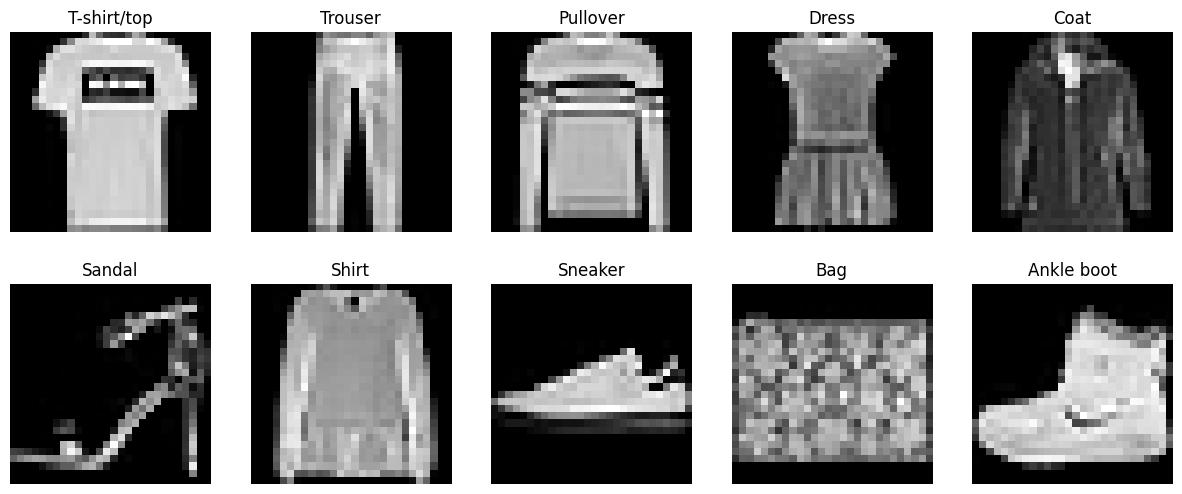

In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist

# Initialize W&B run with the project name
wandb.init(project='fashion-mnist-hyperparam-tuning', name='plot-samples')

# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Class names for Fashion-MNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Plot 1 sample image for each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    # Find the first occurrence of each class
    idx = np.where(y_train == i)[0][0]
    axes[i // 5, i % 5].imshow(X_train[idx], cmap='gray')
    axes[i // 5, i % 5].set_title(class_names[i])
    axes[i // 5, i % 5].axis('off')

# Log the figure to W&B
wandb.log({"fashion_mnist_samples": wandb.Image(fig)})

# Finish the W&B run
wandb.finish()
